# Import Packages

In [6]:
import json
import os
import time
import warnings
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from scipy.optimize import linear_sum_assignment
from sentence_transformers import SentenceTransformer
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from skopt.space import Categorical
from skopt.utils import point_asdict
from sklearn.base import BaseEstimator
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    confusion_matrix,
    normalized_mutual_info_score,
    silhouette_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
import joblib

warnings.filterwarnings("ignore", category=UserWarning)

# Load Data

In [7]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# Embedding

In [ ]:
# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
SBERT_MODEL  = "all-MiniLM-L6-v2"  

# ---------------------------
# SBERT Embeddings
# ---------------------------
texts_sample = df_min_cleaned_sample["text"].astype(str).tolist()
texts_full   = df_min_cleaned["text"].astype(str).tolist()

le = LabelEncoder()

all_labels = pd.concat([
    df_min_cleaned["airline_sentiment"].astype(str),
    df_min_cleaned_sample["airline_sentiment"].astype(str)
], axis=0)
le.fit(all_labels)

# Transform in the same row order as texts_sample/texts_full 
y_full   = le.transform(df_min_cleaned["airline_sentiment"].astype(str))
y_sample = le.transform(df_min_cleaned_sample["airline_sentiment"].astype(str))

sbert = SentenceTransformer(SBERT_MODEL)
EMB_DIM = sbert.get_sentence_embedding_dimension()

os.makedirs("model", exist_ok=True)

EMB_PATH = "model/X_sbert_full.npy"

if os.path.exists(EMB_PATH):
    print("Loading cached embeddings...")
    X_sbert_full = np.load(EMB_PATH, mmap_mode="r")
else:
    print("Computing embeddings (first run)...")
    X_sbert_full = sbert.encode(
        texts_full,
        batch_size=256,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=False
    )
    np.save(EMB_PATH, X_sbert_full)
    print(f"Saved embeddings → {EMB_PATH}")

SAMPLE_PATH = "model/X_sbert_sample.npy"

if os.path.exists(SAMPLE_PATH):
   print("Loading cached sample embeddings...")
   X_sbert_sample = np.load(SAMPLE_PATH, mmap_mode="r")
else:
   print("Computing sample embeddings (first run)...")
   X_sbert_sample = sbert.encode(
       texts_sample, 
       batch_size=256, 
       convert_to_numpy=True, 
       show_progress_bar=True, 
       normalize_embeddings=False
    )
   np.save(SAMPLE_PATH, X_sbert_sample)
   print(f"Saved sample embeddings → {SAMPLE_PATH}")

Computing embeddings (first run)...


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Saved embeddings → model/X_sbert_full.npy
Computing sample embeddings (first run)...


Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Saved sample embeddings → model/X_sbert_sample.npy


# Helper Functions

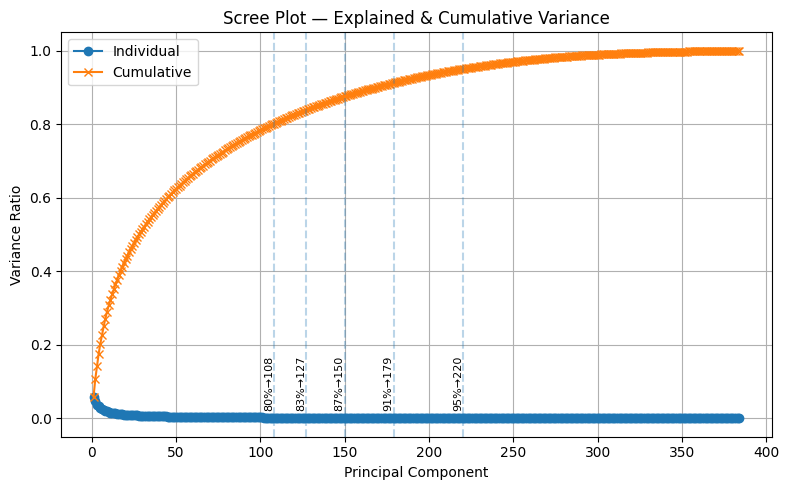

PCA n_components candidates (80–95% cum var): [108, 127, 150, 179, 220]


In [25]:
# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe
    seen, comps_unique = set(), []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        cand = min(max_components, comps_unique[-1] + step)
        if cand not in seen:
            comps_unique.append(cand); seen.add(cand)
        else:
            cand = min(max_components, cand+1)
            if cand not in seen:
                comps_unique.append(cand); seen.add(cand)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_sbert_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# UMAP candidate grids 
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline (tuning version with fast UMAP)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })

        # ---------------- Reducer ----------------
        if self.reducer == 'pca':
            self.reducer_ = PCA(n_components=self.n_components, random_state=RANDOM_STATE)
            X_std = StandardScaler().fit_transform(X)
            X_red = self.reducer_.fit_transform(X_std)
            self.metric = "cosine"   # same metric you used for Agglo/KMeans after PCA
        else:
            self.reducer_ = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            )
            X_l2 = normalize(X)
            X_red = self.reducer_.fit_transform(X_l2)
            self.metric = "cosine"

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            self.clusterer_ = KMeans(
                n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE
            )
            X_use = normalize(X_red)
            labels = self.clusterer_.fit_predict(X_use)

        elif self.model == 'gmm':
            self.clusterer_ = GaussianMixture(
                n_components=3, n_init=10, random_state=RANDOM_STATE,
                covariance_type=self.cov_type
            )
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = self.clusterer_.fit_predict(X_use)
            except ValueError:
                # small safeguard for numerical issues
                self.clusterer_ = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                )
                labels = self.clusterer_.fit_predict(X_use)
            self.metric = "euclidean"

        else:  # Agglomerative
            self.clusterer_ = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            )
            X_use = normalize(X_red)
            labels = self.clusterer_.fit_predict(X_use)
            self.metric = "cosine"

        # ---------------- Store Results ----------------
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)

        return self

    def score(self, X, y=None):
        return self.score_

# BayesSearchCV

In [26]:
# ---------------------------
# Conditional search space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback ---
TOTAL_ITERS = 60
_timings, _start, _prev = [], [None], [None]

def _infer_branch_from_space(space):
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if cats and hasattr(cats, "__iter__") and len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    now = time.perf_counter()
    if _start[0] is None: _start[0] = now
    if _prev[0] is not None: _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try params → else infer branch from subspace
    branch = None
    try:
        if res.x_iters:
            lp = point_asdict(res.space, res.x_iters[-1])
            r, m = lp.get("reducer"), lp.get("model")
            if r and m: branch = f"{r}+{m}"
    except Exception:
        pass
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run BayesSearchCV on SBERT sample
# ---------------------------
n = X_sbert_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)  # placeholder to satisfy BayesSearchCV.fit
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,
    n_jobs=-1,
    return_train_score=False
)

print("\n=== Running BayesSearchCV (SBERT + PCA/UMAP × KMeans/GMM/Agglo) ===")
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

callbacks = [DeltaYStopper(delta=1e-4, n_best=15), progress_callback]

# === Refit best params on FULL data and save ===
os.makedirs("model", exist_ok=True)
SUBSET_PIPE = "model/sbert_pipeline.pkl"
META_JSON   = "model/sbert_pipeline_meta.json"

if os.path.exists(SUBSET_PIPE) and os.path.exists(META_JSON):
    print("Cached best pipeline & meta already exist.")
else:
    print("Running BayesSearchCV (first time or meta missing)...")
    search.fit(X_sbert_sample, dummy_y, callback=callbacks)
    best_estimator = search.best_estimator_

    # ============================================================
    # AFTER: search.fit(X_sbert_sample, dummy_y, callback=callbacks)
    # Build and persist per-branch best (subset), then pick
    # the FULL-data winner by Hungarian and save the fitted model.
    # ============================================================
    cv = pd.DataFrame(search.cv_results_)
    param_cols = [c for c in cv.columns if c.startswith("param_")]
    score_col  = "mean_test_score"

    # ---- 1) Per-branch best on subset (by silhouette) ----
    cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer')}+{r.get('param_model')}", axis=1)
    best_idx = cv.groupby("branch")[score_col].idxmax()
    best_rows = cv.loc[best_idx].reset_index(drop=True)

    branch_best = {}
    for _, r in best_rows.iterrows():
        params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
        # cast numerics
        for k in ("n_components","n_neighbors","n_components_umap"):
            if k in params and params[k] is not None: params[k] = int(params[k])
        if "min_dist" in params and params["min_dist"] is not None:
            params["min_dist"] = float(params["min_dist"])
        key = f"{params.get('reducer')}+{params.get('model')}"
        branch_best[key] = {
            "silhouette_subset": float(r[score_col]),
            **params
        }

    # ---- 2) Evaluate each branch winner on FULL data; pick Hungarian winner ----
    assert "X_sbert_full" in globals(), "Need X_sbert_full in memory."
    assert "y_full" in globals(), "Need y_full labels to compute Hungarian."

    full_eval_rows = []
    best_hungarian = -1.0
    best_record    = None
    best_fitted    = None

    for bkey, rec in branch_best.items():
        params = {k: rec.get(k) for k in [
            "reducer","model","n_components","n_neighbors","min_dist",
            "n_components_umap","cov_type","linkage"
        ] if rec.get(k) is not None}

        mdl = ClusteringPipeline(**params).fit(X_sbert_full)
        labels = mdl.labels_
        metric = getattr(mdl, "metric", "cosine")
        sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)

        row = {
            "branch": bkey,
            "params": params,
            "Silhouette": float(sil),
            "ARI": float(ari),
            "NMI": float(nmi),
            "Hungarian": float(acc),
            "metric_used": metric
        }
        full_eval_rows.append(row)

        if acc > best_hungarian:
            best_hungarian = acc
            best_record    = row
            best_fitted    = mdl

    # ---- 3) Persist meta → sbert_pipeline_meta.json ----
    META_JSON = "model/sbert_pipeline_meta.json"
    meta_payload = {
        "branch_bests": branch_best,      # per-branch best on subset (silhouette)
        "full_eval": full_eval_rows,      # each branch refit on FULL with all metrics
        "winner_metric": "Hungarian",
        "winner": {
            "branch": best_record["branch"],
            "params": best_record["params"],
            "Silhouette": best_record["Silhouette"],
            "ARI": best_record["ARI"],
            "NMI": best_record["NMI"],
            "Hungarian": best_record["Hungarian"],
            "metric_used_for_silhouette": best_record["metric_used"]
        }
    }
    with open(META_JSON, "w") as f:
        json.dump(meta_payload, f, indent=2)
    print(f"Saved meta (per-branch + full eval + winner) → {META_JSON}")

    # ---- 4) Save the best FULL model by Hungarian → sbert_pipeline.pkl ----
    SUBSET_PIPE = "model/sbert_pipeline.pkl"
    joblib.dump(best_fitted, SUBSET_PIPE)
    print(f"Saved BEST (by Hungarian on FULL) pipeline → {SUBSET_PIPE}")



=== Running BayesSearchCV (SBERT + PCA/UMAP × KMeans/GMM/Agglo) ===
Running BayesSearchCV (first time or meta missing)...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Bayes] iter   4/60 ( 6.7%) | last 12.91s avg 12.91s | elapsed  0.2m ETA ~12.1m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last  9.28s avg 11.10s | elapsed  0.4m ETA ~ 9.6m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  6.85s avg  9.68s | elapsed  0.5m ETA ~ 7.7m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  2.42s avg  7.87s | elapsed  0.5m ETA ~ 5.8m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  1.52s avg  6.60s | elapsed  0.5m ETA ~ 4.4m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  1.60s avg  5.76s | elapsed  0.6m ETA ~ 3.5m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  1.67s avg  5.18s | elapsed  0.6m ETA ~ 2.8m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last  2.55s avg  4.85s | elapsed  0.6m ETA ~ 2.3m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  8.59s avg  5.27s | elapsed  0.8m ETA ~ 2.1m | branch pca+kmeans
[Bayes] iter  40/60 (66.7%) | last  4.23s avg  5.16s | elapsed  0.9m ETA ~ 1.7m | branch pca+kmeans


In [27]:
META_JSON = "model/sbert_pipeline_meta.json"
assert os.path.exists(META_JSON), "Missing model/sbert_pipeline_meta.json — run the tuning step first."

with open(META_JSON, "r") as f:
    meta = json.load(f)

# ---------------------------
# Build: Best per branch (SBERT, 20% subset) table
# ---------------------------
branch_bests = meta["branch_bests"]  # dict: key="reducer+model" → params + silhouette_subset

rows = []
for branch, rec in sorted(branch_bests.items()):
    rows.append({
        "branch": branch,
        "best_sil_subset": round(float(rec.get("silhouette_subset", np.nan)), 4),
        "reducer": rec.get("reducer"),
        "model": rec.get("model"),
        "n_components": rec.get("n_components"),
        "n_neighbors": rec.get("n_neighbors"),
        "min_dist": rec.get("min_dist"),
        "n_components_umap": rec.get("n_components_umap"),
        "cov_type": rec.get("cov_type"),
        "linkage": rec.get("linkage"),
    })

df_best_subset = pd.DataFrame(rows).sort_values("branch")

print("\n================ Best Parameters per Branch (SBERT, 20% subset) ================\n")
print(df_best_subset[[
    "branch","best_sil_subset","reducer","model","n_components",
    "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))

# ---------------------------
# Build: Final Evaluation on Full table
# ---------------------------
def _params_compact(d):
    # compact, branch-aware param string
    out = [f"reducer={d['reducer']}", f"model={d['model']}"]
    if d["reducer"] == "pca":
        if d.get("n_components") is not None: out.append(f"n_components={d['n_components']}")
    elif d["reducer"] == "umap":
        for k in ("n_neighbors","min_dist","n_components_umap"):
            if d.get(k) is not None: out.append(f"{k}={d[k]}")
    if d["model"] == "gmm" and d.get("cov_type") is not None:
        out.append(f"cov_type={d['cov_type']}")
    if d["model"] == "agglo" and d.get("linkage") is not None:
        out.append(f"linkage={d['linkage']}")
    return ", ".join(out)

full_eval_rows = meta["full_eval"]  # list of dicts for each branch (Silhouette, ARI, NMI, Hungarian, params, etc.)

final_rows = []
for rec in sorted(full_eval_rows, key=lambda x: x["branch"]):
    params = rec["params"]
    row = {
        "branch": rec["branch"],
        "Silhouette": round(float(rec["Silhouette"]), 3) if rec["Silhouette"] is not None else np.nan,
        "ARI": round(float(rec["ARI"]), 3) if rec["ARI"] is not None else np.nan,
        "NMI": round(float(rec["NMI"]), 3) if rec["NMI"] is not None else np.nan,
        "Hungarian": round(float(rec["Hungarian"]), 3) if rec["Hungarian"] is not None else np.nan,
        "Params": _params_compact(params)
    }
    final_rows.append(row)

df_final = pd.DataFrame(final_rows).sort_values("branch")

print("\n================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branch) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))

# ---------------------------
# Winner lines (guard against all-NaN columns)
# ---------------------------
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
    ser = df_final[metric]
    if ser.notna().any():
        r = df_final.loc[ser.idxmax()]
        print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")


================ Best Parameters per Branch (SBERT, 20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type  linkage
  pca+agglo           0.0518     pca  agglo         150.0          NaN       NaN                NaN     None complete
    pca+gmm           0.0479     pca    gmm         108.0          NaN       NaN                NaN     full     None
 pca+kmeans           0.0920     pca kmeans         108.0          NaN       NaN                NaN     None     None
 umap+agglo           0.5006    umap  agglo           NaN         45.0       0.1               16.0     None complete
   umap+gmm           0.3319    umap    gmm           NaN         60.0       0.1               96.0     tied     None
umap+kmeans           0.5029    umap kmeans           NaN        100.0       0.1               16.0     None     None

================ Final Evaluation on Full Minimal-Cleaned Data (SBERT — Best of Each Branc

# Visualisation

Best model (by Hungarian): umap+gmm
Params: {'reducer': 'umap', 'model': 'gmm', 'n_neighbors': 60, 'min_dist': 0.1, 'n_components_umap': 96, 'cov_type': 'tied'}


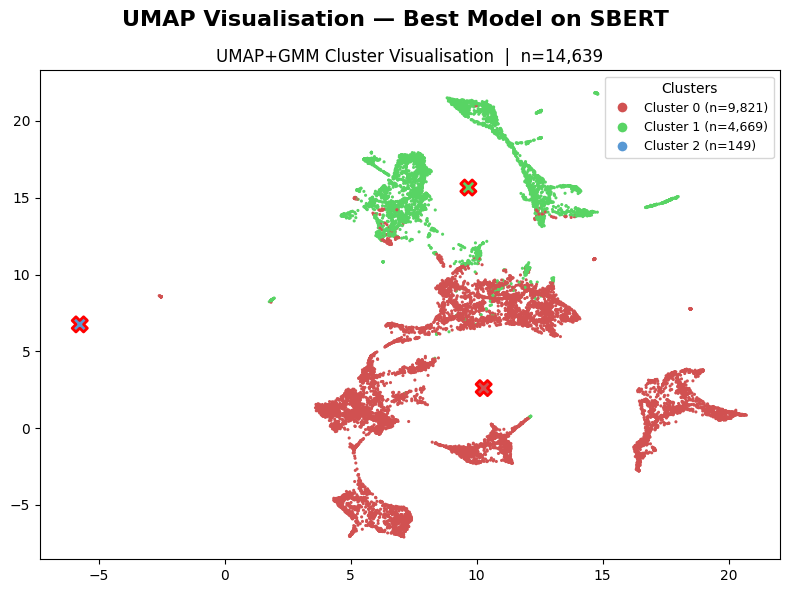

In [28]:
# ===========================
# Visualise the best saved model (Hungarian winner)
# ===========================

RANDOM_STATE = 42
palette = ["#d15151", "#58d464", "#5898d4"]  # red / green / blue

# Load saved artifacts
META_JSON = "model/sbert_pipeline_meta.json"
PIPE_PATH = "model/sbert_pipeline.pkl"
EMB_PATH  = "model/X_sbert_full.npy"

with open(META_JSON, "r") as f:
    meta = json.load(f)
winner = meta["winner"]

print(f"Best model (by Hungarian): {winner['branch']}")
print("Params:", winner["params"])

best = joblib.load(PIPE_PATH)
X_sbert_full = np.load(EMB_PATH, mmap_mode="r")
labels = best.labels_

# ---------------------------
# Reduce to 2D for plotting 
# ---------------------------
umap_2d = umap.UMAP(
    n_neighbors=50, min_dist=0.1, n_components=2,
    metric="euclidean", random_state=RANDOM_STATE
)
X_vis = umap_2d.fit_transform(best.X_use_)   # use the same normalized feature space used for clustering

# ---------------------------
# Plot 
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))
colors = np.array(palette)[labels]
ax.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=5, edgecolor="none")

# Legend
unique, counts = np.unique(labels, return_counts=True)
handles = [plt.Line2D([0],[0], marker='o', color='w',
                      label=f"Cluster {k} (n={counts[i]:,})",
                      markerfacecolor=palette[k], markersize=8)
           for i,k in enumerate(unique)]
ax.legend(handles=handles, title="Clusters", loc="best", fontsize=9)

# Centroids
centroids = np.vstack([X_vis[labels==k].mean(axis=0) for k in unique])
ax.scatter(centroids[:,0], centroids[:,1], s=120, marker="X",
           c=[palette[k] for k in unique], edgecolor="red", linewidth=2.0, zorder=3)

# Titles
ax.set_title(f"{winner['branch'].upper()} Cluster Visualisation  |  n={len(labels):,}", fontsize=12)
plt.suptitle("UMAP Visualisation — Best Model on SBERT", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()